In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import urllib.request
import matplotlib.pyplot as plt

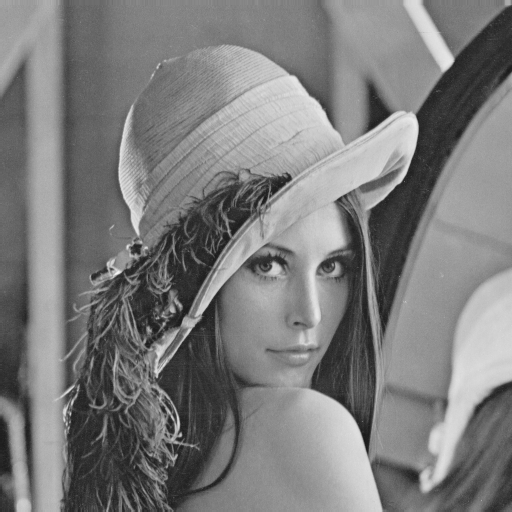

In [2]:
url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"

#Wikipedia does not accept requests from python scripts, so we change the script "identity" by using
#User-Agent
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

req = urllib.request.Request(url, headers=headers)
with urllib.request.urlopen(req) as response:
    with open("lenna.png", "wb") as out_file:
        out_file.write(response.read())

#In the first phase, we will work with black and white images
img_pil = Image.open("lenna.png").convert("L")
img_pil

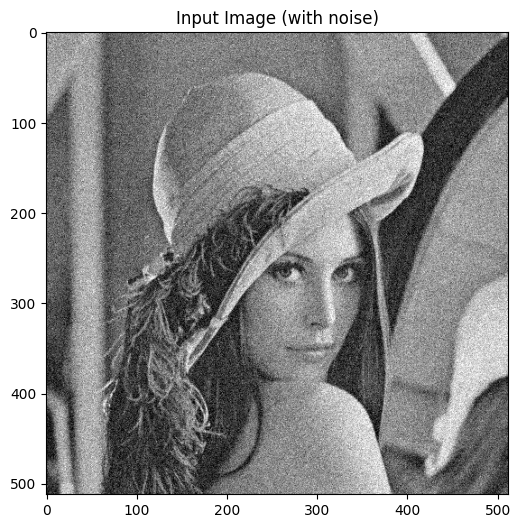

In [3]:
# NN require tensors with normalised values(between 0.0 and 1.0)
transform = transforms.ToTensor()

# apply the transformation, add a "batch" dimension (required by PyTorch), and move the data to the GPU memory (.cuda)
img_clean = transform(img_pil).unsqueeze(0).cuda()

# generate gaussian noise with StandardDeviation = 0.09
sigma = 0.09
noise = sigma * torch.randn_like(img_clean)

# add noise to the image and make sure and make sure the values are in [0.0, 1.0]
img_noisy = torch.clamp(img_clean + noise, 0.0, 1.0)

# matplotlib only works with cpu, so we bring the image from the gpu
plt.figure(figsize=(6, 6))
plt.title("Input Image (with noise)")
plt.imshow(img_noisy[0, 0].cpu().numpy(), cmap='gray')
plt.show()

In [4]:
def get_potentials(height, width, device):
  #center coordonates
  cx = width / 2.0
  cy = height / 2.0

  #generate a coordinate grid for every pixel. The "device" argument ensures this grid is built directly on the gpu
  y = torch.arange(height, device = device).float()
  x = torch.arange(width, device = device).float()
  yy, xx = torch.meshgrid(y, x, indexing='ij')

  #calculate the sqaure distance from the center for each pixel
  dist_sq = (xx - cx) ** 2 + (yy - cy) ** 2

  # spatial weight formula
  p = 1.0 / 1.0 + dist_sq

  #create a deep copy for q
  q = p.clone()

  # reshape the 2d maps (H, W) into 4d tensors (Batch, Channel, H, W)
  return p.unsqueeze(0).unsqueeze(0), q.unsqueeze(0).unsqueeze(0)